<h1><center>Data Science Jobs on Indeed - Dashboard</center></h1>

In [1]:
import numpy as np
import pandas as pd
from os import listdir
import ipywidgets as widgets

# plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
sns.set_style("whitegrid")

In [3]:
# create dataframe from all csv files of weekly scraped data

# load split up test data - each csv file -> one week of job ads
weekly_data_folder = './data/' #split_up_test_data/'

# all filenames in weekly_data directory
weekly_data_files = listdir(weekly_data_folder)

# get df from first file
all_times_df = pd.read_json(weekly_data_folder + weekly_data_files[0])

for file in weekly_data_files[1:]:
    # append dataframes from other files
    all_times_df = all_times_df.append(pd.read_json(weekly_data_folder + file), ignore_index=True)

# sort by date, drop duplicates, create new index
all_times_df = all_times_df.sort_values(by='date')
all_times_df.drop_duplicates(inplace=True, ignore_index=True)

In [4]:
# get uniform salary values

year_hours = 2088
year_days = 261
year_months = 12

def get_start_values(salary_str):
    if salary_str == None:
        return np.nan
    else:
        start_str = salary_str.split(' € ')[0].replace('.', '').replace(',', '.')
        start_num = pd.to_numeric(start_str)
        if 'Stunde' in salary_str:
            return start_num * year_hours
        elif 'Tag' in salary_str:
            return start_num * year_days
        elif 'Monat' in salary_str:
            return start_num * year_months
        elif 'Jahr' in salary_str:
            return start_num
    
def get_end_values(salary_str):
    if salary_str == None:
        return np.nan
    elif not '-' in salary_str:
        return np.nan
    else:
        end_str = salary_str.split(' € ')[1].replace('- ', '').replace('.', '').replace(',', '.')
        end_num = pd.to_numeric(end_str)
        if 'Stunde' in salary_str:
            return end_num * year_hours
        elif 'Tag' in salary_str:
            return end_num * year_days
        elif 'Monat' in salary_str:
            return end_num * year_months
        elif 'Jahr' in salary_str:
            return end_num

# add two new columns: hourly_wage_from, hourly_wage_to
all_times_df['annual_income_from'] = all_times_df['salary'].apply(get_start_values)
all_times_df['annual_income_to'] = all_times_df['salary'].apply(get_end_values)

# round values to 2 decimals
all_times_df = all_times_df.round({'hourly_wage_from':2, 'hourly_wage_to':2})

In [5]:
# keep only 'Berlin' for district names of Berlin as location value (e.g. 'Berlin-Kreuzberg')

all_times_df['location'] = all_times_df['location'].apply(lambda loc: 'Berlin' if 'Berlin' in loc else loc)

In [6]:
# get data of most recent week

# most recent date in data set
most_recent_week_end = all_times_df['date'].max()
# start of the week should always be monday
if most_recent_week_end.weekday() == 6:
    most_recent_week_start = most_recent_week_end - pd.Timedelta('6 days')
elif most_recent_week_end.weekday() == 5:
    most_recent_week_start = most_recent_week_end - pd.Timedelta('5 days')
elif most_recent_week_end.weekday() == 4:
    most_recent_week_start = most_recent_week_end - pd.Timedelta('4 days')
elif most_recent_week_end.weekday() == 3:
    most_recent_week_start = most_recent_week_end - pd.Timedelta('3 days')
elif most_recent_week_end.weekday() == 2:
    most_recent_week_start = most_recent_week_end - pd.Timedelta('2 days')
elif most_recent_week_end.weekday() == 1:
    most_recent_week_start = most_recent_week_end - pd.Timedelta('1 days')
elif most_recent_week_end.weekday() == 0:
    most_recent_week_start = most_recent_week_end
    
most_recent_week_df = all_times_df[(all_times_df['date'] >= most_recent_week_start) & (all_times_df['date'] <= most_recent_week_end)]

In [7]:
first_date = all_times_df['date'].min()
last_date = all_times_df['date'].max()

def job_ads_by_date_df(company):
    '''Returns dataframe, integer value for maximum ads per day and range of dates
    that are used in function plot_ads_over_time_by_company. The dataframe represents
    the number of job ads per day for either a specific company or all companies
    together. each datapoint is split in three seperate datapoints which are used in
    plot_job_ads_by_date to display bars that are split into a low, mid and hich section.'''
    
    # get dataframe for all job ads
    if company == 'ALL_COMPANIES':
        ads_over_time_per_company_df = all_times_df['date'] \
            .value_counts().rename_axis('date').reset_index(name='count')
    
    # get dataframe for job ads from specific company
    else:
        ads_over_time_per_company_df = all_times_df[all_times_df['company'] == company]['date'] \
            .value_counts().rename_axis('date').reset_index(name='count')

    # add dates without ads to dataframe
    #first_date = all_times_df['date'].min()
    #last_date = all_times_df['date'].max()
    days_apart = (last_date - first_date).days
    all_dates = [first_date + pd.Timedelta(days=diff) for diff in range(0, days_apart + 1)]
    for date in all_dates:
        if date in ads_over_time_per_company_df['date'].values:
            continue
        else:
            ads_over_time_per_company_df = \
                ads_over_time_per_company_df.append(pd.DataFrame({'date':[date], 'count':[0]}))

    # set variables for low, mid, high section of each bar
    max_count = ads_over_time_per_company_df['count'].max()
    low_to_mid = max_count // 3 + (1 if max_count%3 != 0 else 0)
    mid_to_high = low_to_mid + max_count // 3 + (max_count % 3) // 2

    # create dataframe where values are split into low, mid and high values for barplot
    low_mid_high_df = pd.DataFrame({'date':[], 'count':[], 'value':[]})
    for idx, row in ads_over_time_per_company_df.iterrows():
        if row['count'] <= low_to_mid:
            low_mid_high_df = low_mid_high_df.append(pd.DataFrame({
                'date': [row['date'], row['date'], row['date']],
                'count': [row['count'], 0, 0],
                'value': ['low', 'mid', 'high']
            }))
        elif row['count'] <= mid_to_high:
            low_mid_high_df = low_mid_high_df.append(pd.DataFrame({
                'date': [row['date'], row['date'], row['date']],
                'count': [low_to_mid, row['count'], 0],
                'value': ['low', 'mid', 'high']
            }))
        else:
            low_mid_high_df = low_mid_high_df.append(pd.DataFrame({
                'date': [row['date'], row['date'], row['date']],
                'count': [low_to_mid, mid_to_high, row['count']],
                'value': ['low', 'mid', 'high']
            }))
    return (low_mid_high_df.sort_values(by='date').reset_index(), max_count, all_dates)

In [8]:
def plot_job_ads_by_date(company):
    '''Plots barplot of the amount of job ads from company given as function parameter.
    The plot is a barplot where each bar is seperated in low, mid, and high section,
    each with a different color to highligh days where a lot of ads were listed'''

    low_mid_high_df, max_count, all_dates = job_ads_by_date_df(company)

    # barplot
    plt.figure(figsize=(25, 5))

    # first layer of bars if highest number of ads per day is at least 3
    if max_count >= 3:
        ads_over_time_per_company_high = sns.barplot(
            data=low_mid_high_df[low_mid_high_df['value'] == 'high'],
            x='date',
            y='count',
            color='red'
        )

    # second layer of bars if highest number of ads per day is at least 2
    if max_count >= 2:
        ads_over_time_per_company_mid = sns.barplot(
            data=low_mid_high_df[low_mid_high_df['value'] == 'mid'],
            x='date',
            y='count',
            color='yellow'
        )

    # third layer of bars
    ads_over_time_per_company_low = sns.barplot(
        data=low_mid_high_df[low_mid_high_df['value'] == 'low'],
        x='date',
        y='count',
        color='green'
    )
    
    # x-ticks
    x_ticks = [f'{date.date()} - {date.day_name()[:2]}' if date.day_name() == 'Monday' \
                   else date.day_name()[:2] for date in all_dates]
    ads_over_time_per_company_low.set_xticklabels(x_ticks, rotation=90, ha='center')

    # y-ticks
    y_ticks = [i for i in range(0, max_count + 3, (1 if company != 'ALL_COMPANIES' else 20))]
    ads_over_time_per_company_low.set_yticks(y_ticks)
    ads_over_time_per_company_low.set_yticklabels(y_ticks)
    
    # label x-axis
    plt.xlabel(None)
    
    # label y-axis
    plt.ylabel('job ads listed per day')
    
    # plot title
    plt.title(f'Job Ads Listed Over Time By "{company}"' if company != 'ALL_COMPANIES' \
                  else 'Total Job Ads Listed Over Time')

    plt.plot()

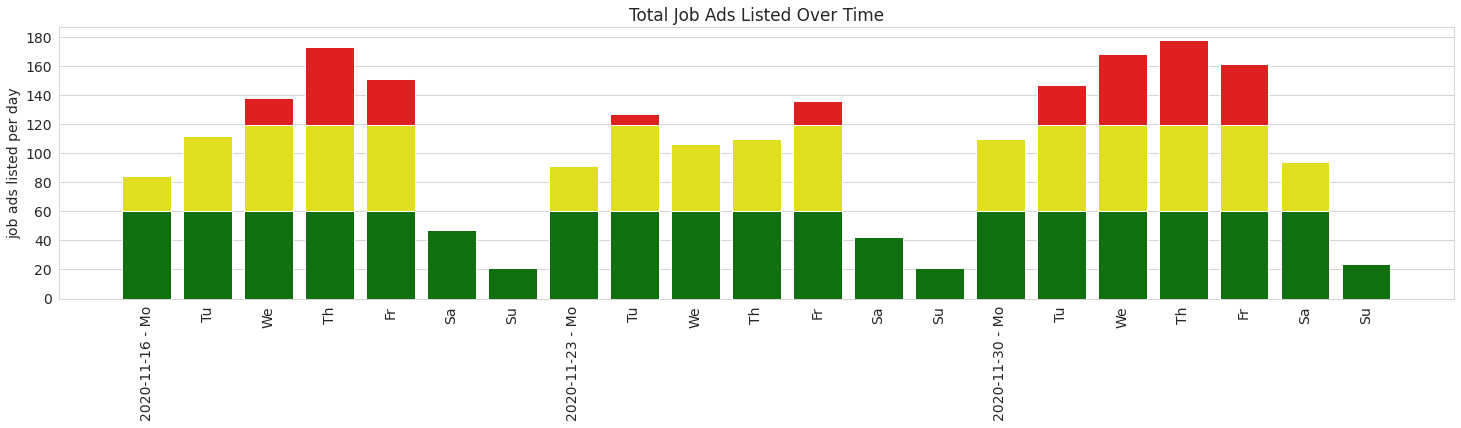

In [9]:
plot_job_ads_by_date('ALL_COMPANIES')

In [21]:
def plot_percentages(ax, total):
    '''Adds percentage values to barplot with absolute values above each bar.
    Expects ax and total value as input.'''
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:.1f}%'.format(100 * height/total),
                ha="center")

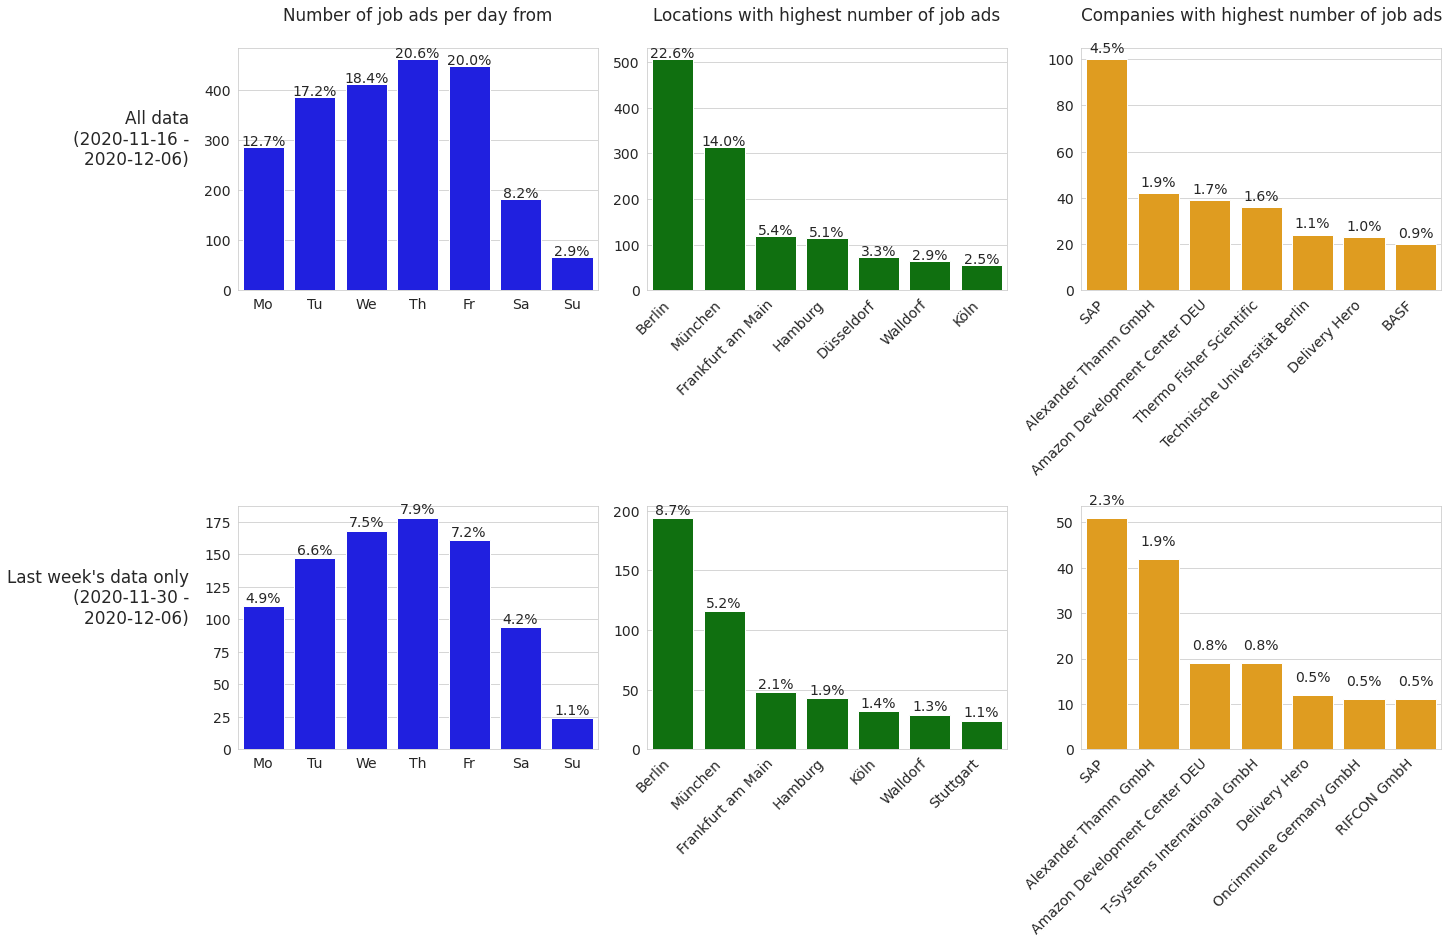

In [22]:
fig, axes = plt.subplots(2, 3, constrained_layout=True)

sns.barplot(ax=axes[0, 0], x=all_times_df['date'].dt.weekday.value_counts().index.values, y=all_times_df['date'].dt.weekday.value_counts().values, color='blue')
sns.barplot(ax=axes[0, 1], x=all_times_df['location'].value_counts()[:7].index.values, y=all_times_df['location'].value_counts()[:7].values, color='green')
sns.barplot(ax=axes[0, 2], x=all_times_df['company'].value_counts()[:7].index.values, y=all_times_df['company'].value_counts()[:7].values, color='orange')
sns.barplot(ax=axes[1, 0], x=most_recent_week_df['date'].dt.weekday.value_counts().index.values, y=most_recent_week_df['date'].dt.weekday.value_counts().values, color='blue')
sns.barplot(ax=axes[1, 1], x=most_recent_week_df['location'].value_counts()[:7].index.values, y=most_recent_week_df['location'].value_counts()[:7].values, color='green')
sns.barplot(ax=axes[1, 2], x=most_recent_week_df['company'].value_counts()[:7].index.values, y=most_recent_week_df['company'].value_counts()[:7].values, color='orange')

# add percentage value above each bar of each plot
total_all_times = len(all_times_df)
total_most_recent_week = len(all_times_df)
plot_percentages(axes[0, 0], total_all_times)
plot_percentages(axes[0, 1], total_all_times)
plot_percentages(axes[0, 2], total_all_times)
plot_percentages(axes[1, 0], total_most_recent_week)
plot_percentages(axes[1, 1], total_most_recent_week)
plot_percentages(axes[1, 2], total_most_recent_week)

axes[0, 0].set_xticklabels(['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su'])
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
axes[0, 2].set_xticklabels(axes[0, 2].get_xticklabels(), rotation=45, ha='right')
axes[1, 0].set_xticklabels(['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su'])
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), rotation=45, ha='right')

axes[0, 0].set_title('Number of job ads per day from\n')
axes[0, 1].set_title('Locations with highest number of job ads\n')
axes[0, 2].set_title('Companies with highest number of job ads\n')

axes[0, 0].set_ylabel(f'All data  \n({first_date.date()} -  \n{last_date.date()})  ', rotation=0, ha='right', size='large')
axes[1, 0].set_ylabel(f"Last week's data only  \n({most_recent_week_start.date()} -  \n{most_recent_week_end.date()})  ", rotation=0, ha='right', size='large')

fig.set_size_inches(20, 13)

plt.show()

In [13]:
def ads_per_week_per_city_df(city):
    '''Returns dataframe with amount of job ads per week coming from either
    a specific city or the n cities with the most job ads overall.
    Expects either city name as string or number of cities with most job ads
    as int.'''
    
    first_date = all_times_df['date'].min()
    last_date = all_times_df['date'].max()
    all_sundays = pd.date_range(start=first_date, end=last_date, freq='W')
    
    if type(city) != int:
        locs = [city]
    else:
        locs = all_times_df['location'].value_counts()[:city].index.values
        
    df = all_times_df[all_times_df['location'].isin(locs)]
    
    # group by week and location and get number of results in group
    counts_each_week_df = df.groupby([pd.Grouper(key='date', freq='W'), pd.Grouper(key='location')]).size()
    
    # turn series with multi index to dataframe with multi index as columns and reset index
    counts_each_week_df = counts_each_week_df.rename_axis(['week', 'location']).reset_index(name='count')
    
    # add rows for date city comnimations without ads
    for date in all_sundays:
        for loc in locs:
            if not ((counts_each_week_df['week'] == date) & (counts_each_week_df['location'] == loc)).any():
                counts_each_week_df = counts_each_week_df.append(pd.DataFrame({
                    'week': [date], 'location': [loc], 'count': [0]
                }))

    return counts_each_week_df

In [39]:
def plot_ads_per_week_per_city(city, ax):
    '''Plots ads per week for either a specific city or the n cities with
    the most job ads overall. Expects either city name as string or number
    of cities with most job ads as int.'''
    
    df = ads_per_week_per_city_df(city)
    
    if type(city) != int:
        plot = sns.lineplot(data=df, x='week', y='count', ax=ax)
        plot.set_title(f'Ads per week from {city}')
    else:
        plot = sns.lineplot(data=df, x='week', y='count', hue='location', ax=ax)
        plot.set_title(f'Ads per week for 5 locations with the most ads')
        
    # x-ticks
    x_ticks = df['week']
    x_ticklabels = ['{} -\n{}'.format(tick.date() - pd.Timedelta("6 days"), tick.date()) for tick in x_ticks]
    plot.set_xticks(x_ticks)
    plot.set_xticklabels(x_ticklabels, rotation=45)
    
    # y-ticks
    y_max = df['count'].max()
    ticks_distance = y_max // 8 + 1
    y_ticks = [y for y in range(0, y_max + 1, ticks_distance)]
    plot.set_yticks(y_ticks)
    
    # x and y labels
    plot.set_ylabel('number of job ads')
    plot.set_xlabel('')
    
    return plot

In [40]:
def most_ads_companies_per_city_df(location, n):
    '''Returns dataframe with amount of ads from n companies with the most ads.
    Expects location name or "ALL_LOCATIONS" for all cities and n for
    the number of companies as input.'''
    
    if location == 'ALL_LOCATIONS':
        return all_times_df['company'].value_counts()[:n].rename_axis('company').reset_index(name='count')
    else:
        return all_times_df[all_times_df['location'] == location]['company'].value_counts()[:n].rename_axis('company').reset_index(name='count')

In [41]:
def plot_most_ads_companies_per_city(location, n, ax):
    '''Plots barplot of companies with most job ads per location.
    Expects location as string and maximum number of companies in the plot
    as function parameters'''
    
    df = most_ads_companies_per_city_df(location, n)
    
    plot = sns.barplot(data=df, x='company', y='count', ax=ax)
    
    # x-ticks
    plot.set_xticklabels(labels=plot.get_xticklabels(), rotation=45, ha='right')
    
    # y-ticks
    y_max = df['count'].max()
    ticks_distance = y_max // 8 + 1
    y_ticks = [y for y in range(0, y_max + 1, ticks_distance)]
    plot.set_yticks(y_ticks)
    
    # x and y labels
    plot.set_ylabel('number of job ads')
    plot.set_xlabel('')
    
    # title
    if location == 'ALL_LOCATIONS':
        plot.set_title('Companies with most job ads')
    else:
        plot.set_title(f'Companies with most job ads from {location}')
    
    return plot

In [42]:
def plot_city_figs_aggregated(location):
    '''Aggregate plot_ads_per_week_per_city for 5 cities mith most ads,
    plot_ads_per_week_per_city for location given as function parameter and
    plot_most_ads_companies_per_city for 5 companies with most ads from city
    given as input'''
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True)
    
    plot_ads_per_week_per_city(5, ax=ax1)
    plot_ads_per_week_per_city(location, ax=ax2)
    plot_most_ads_companies_per_city(location, 5, ax=ax3)
    
    fig.set_size_inches(20, 6)
    
    plt.show()

**Choose a city below:**

In [43]:
plot_city_figs_aggregated_choice = widgets.interactive(plot_city_figs_aggregated, location=all_times_df['location'].sort_values().unique())
plot_city_figs_aggregated_choice

interactive(children=(Dropdown(description='location', options=('Aachen', 'Aalen', 'Ahlen', 'Augsburg', 'Bad K…

In [19]:
def plot_job_ads_by_date_plus_df(company):
    plot_job_ads_by_date(company)
    display(all_times_df[all_times_df['company'] == company] \
            [['title', 'company', 'location', 'salary', 'description', 'date']].sort_values('date'))

**Choose a company below:**

In [20]:
plot_job_ads_by_date_choice_plus_df = widgets.interactive(plot_job_ads_by_date_plus_df, company=all_times_df['company'].sort_values().unique())
plot_job_ads_by_date_choice_plus_df

interactive(children=(Dropdown(description='company', options=('.companion', '0074-BASF Digital Solutions GmbH…